# MATH 497: Final Project

Remark: 
Please use Jupyter Notebook (Final_Project_yourname.ipynb file) to prepare your final
report, including the output of your code, and submit this on Canvas
by 5pm June 26 Friday EST.

Please summarize your results using Tables, plots and bullet-points
for each problem in a concise, clear and coherent manner.  You are
welcome to organize your presentations using your own style if you
prefer, or you can use the following  as a reference to prepare
your presentation. 

You can also use https://www.tablesgenerator.com/markdown_tables to create your own tables.

=================================================================================================================

## Problem 1 [20%]:  

Consider the following linear system

\begin{equation}\label{matrix}
A\ast u =f,
\end{equation}
or equivalently $u=\arg\min \frac{1}{2} (A* v,v)_F-(f,v)_F$, where $(f,v)_F =\sum\limits_{i,j=1}^{n}f_{i,j}v_{i,j}$ is the Frobenius inner product.
Here $\ast$ represents a convolution with one channel, stride one and zero padding one. The convolution kernel $A$ is given by
$$ 
A=\begin{bmatrix} 0 & -1 & 0 \\ -1 & 4 & -1 \\ 0 & -1 & 0 \end{bmatrix},~~
$$
the solution $ u \in \mathbb{R}^{n\times n} $, and the RHS $ f\in \mathbb{R}^{n\times n}$ is given by $f_{i,j}=\dfrac{1}{(n+1)^2}.$


### Tasks:
Set $J=4$, $n=2^J-1$ and the number of iterations $M=100$. Use the gradient descent method and the multigrid method to solve the above problem with a random initial guess $u^0$. Let $u_{GD}$ and $u_{MG}$ denote the solutions obtained by gradient descent and multigrid respectively.
    
* [5%] Plot the surface of solution $u_{GD}$ and $u_{MG}$.

* [10%] Define error $e_{GD}^m = \|A * u^{m}_{GD}- f\|_F=\sqrt{\sum\limits_{i=1}^{n}\sum\limits_{j=1}^{n} |(A * u^{m}_{GD}- f)_{i,j}}|^2 $ for $m=0,1,2,3,...,M$. Similarly, we define the multigrid error $e_{MG}^m$. Plot the errors $e_{GD}^m$ and $e_{MG}^m$ as a function of the iteration $m$ (your x-axis is $m$ and your y-axis is the error). Put both plots together in the same figure.

* [5%] Find the minimal $m_1$ for which $e^{m_1}_{GD} <10^{-5}$ and the minimal $m_2$ for which $e^{m_2}_{MG} <10^{-5}$, and report the computational time for each method. Note that $m_1$ or $m_2$ may be greater than $M=100$, in this case you will have to run more iterations.

### Remark:

Below are examples of using gradient descent and multigrid iterations for M-times 
* #### For gradient descent method with $\eta=\frac{1}{8}$, you need to write a code:

    Given initial guess $u^0$
$$
\begin{align}
&\text{for    }  m =  1,2,...,M\\
&~~~~\text{for    }  i,j = 1: n\\
&~~~~~~~~u_{i,j}^{m} = u_{i,j}^{m-1}-\eta(f_{i,j}-(A\ast u^{m-1})_{i,j})\\
&~~~~\text{endfor}\\
&\text{endfor}
\end{align} 
$$

* #### For multigrid method, we have provided the framework code in F02_MultigridandMgNet.ipynb:

    Given initial guess $u^0$
$$
\begin{align}
&\text{for    }  m =  1,2,...,M\\
&~~~~u^{m} = MG1(u^{m-1},f, J, \nu)\\
&\text{endfor}
\end{align} 
$$

## Results of Problem 1:


### Task 1

### Show your code for the  Task 1
### Show the plots for the Task 1

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import  torch.nn.functional as F
import torch.optim as optim
import torchvision
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

use_cuda = torch.cuda.is_available()
print('Use GPU?', use_cuda)

    
##### For MG: inilization of A, S, Pi, R, RT #####
def get_mg_init(A=None, S=None, Pi=None, R=None, RT=None):

    A_kernel = torch.tensor([[[[0,-1,0],[-1,4,-1],[0,-1,0]]]],dtype=torch.float32)
    S_kernel = torch.tensor([[[[0,1/64,0],[1/64,12/64,1/64],[0,1/64,0]]]],dtype=torch.float32)
    Pi_kernel = torch.tensor([[[[0,0,0],[0,0,0],[0,0,0]]]],dtype=torch.float32)
    R_kernel = torch.tensor([[[[0,0.5,0.5],[0.5,1,0.5],[0.5,0.5,0]]]],dtype=torch.float32)
    RT_kernel = torch.tensor([[[[0,0.5,0.5],[0.5,1,0.5],[0.5,0.5,0]]]],dtype=torch.float32)

    if A is not None:
        A.weight = torch.nn.Parameter(A_kernel)
    
    if S is not None:
        S.weight = torch.nn.Parameter(S_kernel)
        
    if Pi is not None:
        Pi.weight = torch.nn.Parameter(Pi_kernel)
    
    if R is not None:
        R.weight = torch.nn.Parameter(R_kernel)
    
    if RT is not None:
        RT.weight = torch.nn.Parameter(RT_kernel)
    
    return


##### For MG: setup for prolongation and error calculation #####
RT = nn.ConvTranspose2d(1, 1, kernel_size=3, stride=2, padding=0, bias=False)
get_mg_init(None,None,None,None,RT)
A = nn.Conv2d(1, 1, kernel_size=3,stride=1, padding=1, bias=False)
get_mg_init(A,None,None,None,None)


class MgIte(nn.Module):
    def __init__(self, A, S):
        super().__init__()
        
        get_mg_init(A=A,S=S)                       ##### For MG: inilization of A, S #####

        self.A = A
        self.S = S
    
    def forward(self, out):
        u, f = out
        u = u + (self.S(((f-self.A(u)))))                                   ##### For MG: u = u + S*(f-A*u) #####
        out = (u, f)
        return out


class MgRestriction(nn.Module):
    def __init__(self, A_old, A, Pi, R):
        super().__init__()

        get_mg_init(A=A,Pi=Pi,R=R)            ##### For MG: inilization of A, Pi, R #####
        self.A_old = A_old
        self.A = A
        self.Pi = Pi
        self.R = R

    def forward(self, out):
        u_old, f_old = out
        u = self.Pi(u_old)                              ##### For MG: u = Pi*u_old #####
        f = self.R(f_old-self.A_old(u_old)) + self.A(u) ##### For MG: f = R*(f_old-A_old*u_old) + A*u #####     
        out = (u,f)
        return out


class MG(nn.Module):
    def __init__(self, num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes):
        super().__init__()
        self.num_iteration = num_iteration
        self.num_channel_u = num_channel_u    

        
        A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)
        S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)

        layers = []
        for l, num_iteration_l in enumerate(num_iteration): #l: l-th layer.   num_iteration_l: the number of iterations of l-th layer
            for i in range(num_iteration_l):
                layers.append(MgIte(A, S))

            setattr(self, 'layer'+str(l), nn.Sequential(*layers))

            if l < len(num_iteration)-1:
                A_old = A
                
                A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3,stride=1, padding=1, bias=False)
                S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)

                ##### For MG: padding=0 #####  
                Pi = nn.Conv2d(num_channel_u, num_channel_u, kernel_size=3,stride=2, padding=0, bias=False)
                R  = nn.Conv2d(num_channel_f, num_channel_f, kernel_size=3, stride=2, padding=0, bias=False)              
                
                layers= [MgRestriction(A_old, A, Pi, R)]


    def forward(self, u, f):
        
        out = (u, f) 

        u_list.append(u)                                      ##### For MG: save u^j, j=1,2,...,J #####
        for l in range(len(self.num_iteration)):
            out = getattr(self, 'layer'+str(l))(out) 
            u, f = out                                        ##### For MG: save u^j, j=1,2,...,J #####
            u_list.append(u)                                  ##### For MG: save u^j, j=1,2,...,J #####
        
        return u


def plot_solution(J,u,label_name):
    N = 2 ** J -1
    h = 1/2**J
    X = np.arange(h, 1, h)
    Y = np.arange(h, 1, h)
    X, Y = np.meshgrid(X,Y)   # create a mesh
    a = torch.reshape(u, (N, N))
    fig1 = plt.figure()
    ax = Axes3D(fig1)         # plot a 3D surface, (X,Y,u(X,Y))
    ax.plot_surface(X, Y, np.array(a.data), rstride=1, cstride=1, cmap=plt.cm.coolwarm)
    ax.set_title(label_name)


def MG1(u,f,J,num_iteration):
    u_list.clear()                                     # Save u^0,u^1,u^2,u^3...,u^J
    u = MG0(u,f)
    for j in range(J-1,0,-1):
        u_list[j] += RT(u_list[j+1])
    u = u_list[1]
    return u


# Model setup
num_channel_input = 1
num_channel_u = 1
num_channel_f = 1
num_classes = 1 

J = 4 
num_iteration = [2,2,2,2]
MG0=MG(num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes)

##### For MG: PDE setup u=sin(2*pi*x)*sin(2*pi*y) #####

N = 2 ** J -1
h = 1/2**J
u_exact = torch.ones(1,1,N,N)
f = torch.ones(1,1,N,N) / (N+1) **2


##### For MG: Muligrid iteration #####
M = 100
u = torch.randn(1,1,N,N)
error = [np.linalg.norm((A(u)-f).detach().numpy())]  # calculate the Frobenius Norm of (A*u-f)
u_list =[]                                     # Save u^0,u^1,u^2,u^3...,u^J

for m in range(M):
    u = MG1(u,f,J,num_iteration)
    error.append(np.linalg.norm((A(u)-f).detach().numpy())) # calculate the Frobenius Norm of (A*u-f)


##### Lian added for MG: Plot results #####
print("Problem 1 Task (a): Plot the surface of solution.")
plot_solution(J,u,'Numerical solution')

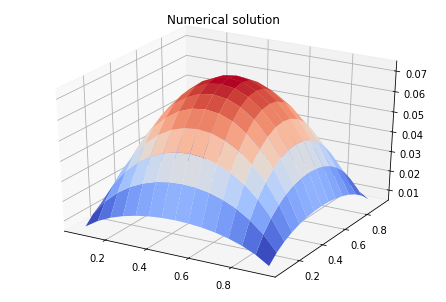

In [1]:
from IPython.display import Image
Image(filename='q1t1.png')

### Task 2

### Show the code for the  Task 2
### Show the plots for the Task 2

In [ ]:
def plot_error(M,error,label_name):
    #print(np.linalg.norm((f-self.A(u)).reshape(-1).detach().numpy()))
    plt.figure()
    plt.title('Error vs number of iterations using '+label_name)
    plot = plt.plot(error)
    plt.xlabel('Number of iterations')
    plt.yscale('log')
    plt.ylabel('Error')
    plt.show()

print("Problem 1 Task (b): Plot the errors of solution.")
plot_error(M,error,'Multigrid')

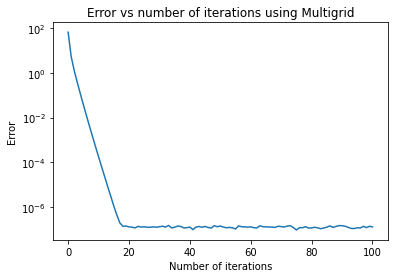

In [2]:
from IPython.display import Image
Image(filename='q1t2.png')

### Task 3

### The following table shows the results of the Task 3:

| Method           | $\nu$ or $\eta$ | #iterations | computational time |
|:-----------------|:-----------|:--------------------|:-------------------|
| Gradient descent |1/8            |100                     |                    |
| Multigrid        |            |100                     |                    |
|                  |            |                     |                    |

### Discussions or Conclusions

#### *  Multigrid has better performance
#### *

=================================================================================================================

## Problem 2 [50%]: 

Use SGD with momentum and weight decay to train MgNet on the Cifar10 dataset. Use 120 epochs, set the initial learning rate to 0.1, momentum to 0.9, weight decay to 0.0005, and divide the learning rate by 10 every 30 epochs. (The code to do this has been provided.) Let $b_i$ denote the test accuracy of the model after $i$ epochs, and let $b^*$ = $\max_i(b_i)$ be the best test accuracy attained during training.


### Tasks:
   * [30%] Train MgNet with the following three sets of hyper-parameters (As a reminder, the hyper-parameters of MgNet are $\nu$, the number of iterations of each layer, $c_u$, the number of channels for $u$, and $c_f$, the number of channels for $f$.):
 
    (1) $\nu=$[1,1,1,1], $c_u=c_f=64$.
    
    (2) $\nu=$[2,2,2,2], $c_u=c_f=64$.

    (3) $\nu=$[2,2,2,2], $c_u=c_f=64$, try to improve the test accuracy by implementing MgNet with $S^{l,i}$, which means different iterations in the same layer do not share the same $S^{l}$. 
  
  
   * For each numerical experiment above, print the results with the following format:

       "Epoch: i, Learning rate: lr$_i$, Training accuracy: $a_i$, Test accuracy: $b_i$"

        where $i=1,2,3,...$ means the $i$-th epoch,  $a_i$ and $b_i$ are the training accuracy and test accuracy computed at the end of $i$-th epoch, and lr$_i$ is the learning rate of $i$-th epoch.
    
    
   * [10%] For each numerical experiment above, plot the test accuracy against the epoch count, i.e. the x-axis is the number of epochs $i$ and y-axis is the test accuracy $b_i$. An example plot is shown in the next cell.
   
   
   * [10%] Calculate the number of parameters that each of the above models has. Discuss why the number of parameters is different (or the same) for each of the models.
       

## Results of Problem 2:


### For (1) $\nu=$[1,1,1,1], $c_u=c_f=64$.

### Show your code 
### Show the print and plots 

In [ ]:
# from IPython.display import Image
# Image(filename='plot_sample_code.png')

import torch
import numpy as np
import torch.nn as nn
import  torch.nn.functional as F
import torch.optim as optim
import torchvision
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

use_cuda = torch.cuda.is_available()
print('Use GPU?', use_cuda)


class MgIte(nn.Module):
    def __init__(self, A, S):
        super().__init__()
        
        self.A = A
        self.S = S
        self.bn1 =nn.BatchNorm2d(A.weight.size(0)) ##### For MgNet: BN #####
        self.bn2 =nn.BatchNorm2d(S.weight.size(0)) ##### For MgNet: BN #####
    
    def forward(self, out):
        u, f = out
        u = u + F.relu(self.bn2(self.S(F.relu(self.bn1((f-self.A(u))))))) ##### For MgNet: add BN and ReLU #####
        out = (u, f)
        return out


class MgRestriction(nn.Module):
    def __init__(self, A_old, A, Pi, R):
        super().__init__()

        self.A_old = A_old
        self.A = A
        self.Pi = Pi
        self.R = R
        self.bn1 = nn.BatchNorm2d(Pi.weight.size(0))   ##### For MgNet: BN #####
        self.bn2 = nn.BatchNorm2d(R.weight.size(0))    ##### For MgNet: BN #####

    def forward(self, out):
        u_old, f_old = out
        u = F.relu(self.bn1(self.Pi(u_old)))                              ##### For MgNet: add BN and ReLU #####
        f = F.relu(self.bn2(self.R(f_old-self.A_old(u_old)))) + self.A(u) ##### For MgNet: add BN and ReLU #####        
        out = (u,f)
        return out


class MG(nn.Module):
    def __init__(self, num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes):
        super().__init__()
        self.num_iteration = num_iteration
        self.num_channel_u = num_channel_u
        
        ##### For MgNet: Initialization layer #####
        self.conv1 = nn.Conv2d(num_channel_input, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_channel_f)        
        
        A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)
        S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)

        layers = []
        for l, num_iteration_l in enumerate(num_iteration): #l: l-th layer.   num_iteration_l: the number of iterations of l-th layer
            for i in range(num_iteration_l):
                layers.append(MgIte(A, S))

            setattr(self, 'layer'+str(l), nn.Sequential(*layers))

            if l < len(num_iteration)-1:
                A_old = A
                
                A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3,stride=1, padding=1, bias=False)
                S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)

                ##### For MgNet: padding=1 #####
                Pi = nn.Conv2d(num_channel_u, num_channel_u, kernel_size=3,stride=2, padding=1, bias=False)
                R = nn.Conv2d(num_channel_f, num_channel_f, kernel_size=3, stride=2, padding=1, bias=False)
                
                layers= [MgRestriction(A_old, A, Pi, R)]
        
        ##### For MgNet: average pooling and fully connected layer for classification #####
        self.pooling = nn.AdaptiveAvgPool2d(1)  # pooling the data in each channel to size=1
        self.fc = nn.Linear(num_channel_u ,num_classes)

    def forward(self, u, f):
        f = F.relu(self.bn1(self.conv1(f)))                 ##### For MgNet: initialization of f #####
        if use_cuda:                                        ##### For MgNet: initialization of u #####
            u = torch.zeros(f.size(0),self.num_channel_u,f.size(2),f.size(3), device=torch.device('cuda'))
        else:
            u = torch.zeros(f.size(0),self.num_channel_u,f.size(2),f.size(3))        
        out = (u, f)

        for l in range(len(self.num_iteration)):
            out = getattr(self, 'layer'+str(l))(out)
        
        ##### For MgNet: average pooling and fully connected layer for classification #####
        u, f = out       
        u = self.pooling(u)
        u = u.view(u.shape[0], -1)
        u = self.fc(u)
        return u

# Divide the learning rate by 10 every 30 epochs
def adjust_learning_rate(optimizer, epoch, init_lr):
    lr = init_lr * 0.1 ** (epoch // 30)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

minibatch_size = 128
num_epochs = 120
lr = 0.1

print("Problem 2 task (1): v=[1,1,1,1], cu=cf=64")
print("Part a:")
num_channel_input = 3
num_channel_u = 64
num_channel_f = 64
num_classes = 10
num_iteration = [1,1,1,1]

# Step 1: Define a model
my_model = MG(num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes)

if use_cuda:
    my_model = my_model.cuda()

# Step 2: Define a loss function and training algorithm
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_model.parameters(), lr=lr, momentum=0.9, weight_decay = 0.0005)

# Step 3: load dataset
normalize = torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
transform_train = torchvision.transforms.Compose([torchvision.transforms.RandomCrop(32, padding=4),
                                                  torchvision.transforms.RandomHorizontalFlip(),
                                                  torchvision.transforms.ToTensor(),
                                                  normalize])
transform_test  = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),normalize])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=minibatch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=minibatch_size, shuffle=False)
start = timer()

accuracy_history = []
#Step 4: Train the NNs
# One epoch is when an entire dataset is passed through the neural network only once.
for epoch in range(num_epochs):

    current_lr = adjust_learning_rate(optimizer, epoch, lr)

    my_model.train()
    for i, (images, labels) in enumerate(trainloader):
        if use_cuda:
          images = images.cuda()
          labels = labels.cuda()

        # Forward pass to get the loss
        outputs = my_model(0,images)   # We need additional 0 input for u in MgNet
        loss = criterion(outputs, labels)
        
        # Backward and compute the gradient
        optimizer.zero_grad()
        loss.backward()  #backpropragation
        optimizer.step() #update the weights/parameters

  # Training accuracy
    my_model.eval()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(trainloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()  
          outputs = my_model(0,images)  # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    training_accuracy = float(correct)/total

    # Test accuracy
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(testloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()
          outputs = my_model(0,images)      # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum()
    test_accuracy = float(correct)/total
    print('Epoch: {}, learning rate: {}, the training accuracy: {}, the test accuracy: {}' .format(epoch+1,current_lr,training_accuracy,test_accuracy)) 
    accuracy_history.append(test_accuracy)

end = timer()
print('Total Computation Time:',end - start)

# Part b: plot test accuracy
print("\nPart b: plot test accuracy")
def plot_accuracy(num_epochs,accuracy_history):
    plt.figure()
    plt.title('Test accuracy against the epoch count')
    plot = plt.plot(accuracy_history)
    plt.xlabel('Number of epochs')
    plt.ylim(0, 1)
    plt.ylabel('Test accuracy')
    plt.show()
plot_accuracy(num_epochs, accuracy_history)


# Calculate model size
model_size = sum(param.numel() for param in my_model.parameters())
print("\nPart c: model size:", model_size)

In [ ]:
# # (1) output:
# 
# Use GPU? True
# Problem 2 task (1): v=[1,1,1,1], cu=cf=64
# Part a:
# Files already downloaded and verified
# Files already downloaded and verified
# Epoch: 1, learning rate: 0.1, the training accuracy: 0.56444, the test accuracy: 0.5677
# Epoch: 2, learning rate: 0.1, the training accuracy: 0.61602, the test accuracy: 0.6146
# Epoch: 3, learning rate: 0.1, the training accuracy: 0.68202, the test accuracy: 0.6669
# Epoch: 4, learning rate: 0.1, the training accuracy: 0.69334, the test accuracy: 0.683
# Epoch: 5, learning rate: 0.1, the training accuracy: 0.73982, the test accuracy: 0.7267
# Epoch: 6, learning rate: 0.1, the training accuracy: 0.77678, the test accuracy: 0.7725
# Epoch: 7, learning rate: 0.1, the training accuracy: 0.72788, the test accuracy: 0.7211
# Epoch: 8, learning rate: 0.1, the training accuracy: 0.73644, the test accuracy: 0.7291
# Epoch: 9, learning rate: 0.1, the training accuracy: 0.74144, the test accuracy: 0.7341
# Epoch: 10, learning rate: 0.1, the training accuracy: 0.7554, the test accuracy: 0.7443
# Epoch: 11, learning rate: 0.1, the training accuracy: 0.8137, the test accuracy: 0.8038
# Epoch: 12, learning rate: 0.1, the training accuracy: 0.78576, the test accuracy: 0.7694
# Epoch: 13, learning rate: 0.1, the training accuracy: 0.81016, the test accuracy: 0.8001
# Epoch: 14, learning rate: 0.1, the training accuracy: 0.78146, the test accuracy: 0.7674
# Epoch: 15, learning rate: 0.1, the training accuracy: 0.78496, the test accuracy: 0.7731
# Epoch: 16, learning rate: 0.1, the training accuracy: 0.77294, the test accuracy: 0.7604
# Epoch: 17, learning rate: 0.1, the training accuracy: 0.81614, the test accuracy: 0.8012
# Epoch: 18, learning rate: 0.1, the training accuracy: 0.73252, the test accuracy: 0.7164
# Epoch: 19, learning rate: 0.1, the training accuracy: 0.80492, the test accuracy: 0.795
# Epoch: 20, learning rate: 0.1, the training accuracy: 0.83464, the test accuracy: 0.8223
# Epoch: 21, learning rate: 0.1, the training accuracy: 0.77324, the test accuracy: 0.7616
# Epoch: 22, learning rate: 0.1, the training accuracy: 0.7862, the test accuracy: 0.7593
# Epoch: 23, learning rate: 0.1, the training accuracy: 0.76944, the test accuracy: 0.7478
# Epoch: 24, learning rate: 0.1, the training accuracy: 0.81042, the test accuracy: 0.7882
# Epoch: 25, learning rate: 0.1, the training accuracy: 0.8123, the test accuracy: 0.7936
# Epoch: 26, learning rate: 0.1, the training accuracy: 0.815, the test accuracy: 0.8009
# Epoch: 27, learning rate: 0.1, the training accuracy: 0.77494, the test accuracy: 0.7697
# Epoch: 28, learning rate: 0.1, the training accuracy: 0.76474, the test accuracy: 0.7516
# Epoch: 29, learning rate: 0.1, the training accuracy: 0.79968, the test accuracy: 0.7877
# Epoch: 30, learning rate: 0.1, the training accuracy: 0.79628, the test accuracy: 0.7883
# Epoch: 31, learning rate: 0.010000000000000002, the training accuracy: 0.90668, the test accuracy: 0.8822
# Epoch: 32, learning rate: 0.010000000000000002, the training accuracy: 0.91356, the test accuracy: 0.8921
# Epoch: 33, learning rate: 0.010000000000000002, the training accuracy: 0.91588, the test accuracy: 0.8907
# Epoch: 34, learning rate: 0.010000000000000002, the training accuracy: 0.92286, the test accuracy: 0.8959
# Epoch: 35, learning rate: 0.010000000000000002, the training accuracy: 0.92442, the test accuracy: 0.8913
# Epoch: 36, learning rate: 0.010000000000000002, the training accuracy: 0.9279, the test accuracy: 0.8973
# Epoch: 37, learning rate: 0.010000000000000002, the training accuracy: 0.92896, the test accuracy: 0.8984
# Epoch: 38, learning rate: 0.010000000000000002, the training accuracy: 0.92906, the test accuracy: 0.8958
# Epoch: 39, learning rate: 0.010000000000000002, the training accuracy: 0.93102, the test accuracy: 0.8924
# Epoch: 40, learning rate: 0.010000000000000002, the training accuracy: 0.9332, the test accuracy: 0.8979
# Epoch: 41, learning rate: 0.010000000000000002, the training accuracy: 0.9351, the test accuracy: 0.8965
# Epoch: 42, learning rate: 0.010000000000000002, the training accuracy: 0.93338, the test accuracy: 0.8986
# Epoch: 43, learning rate: 0.010000000000000002, the training accuracy: 0.93576, the test accuracy: 0.8969
# Epoch: 44, learning rate: 0.010000000000000002, the training accuracy: 0.93894, the test accuracy: 0.8968
# Epoch: 45, learning rate: 0.010000000000000002, the training accuracy: 0.92826, the test accuracy: 0.8917
# Epoch: 46, learning rate: 0.010000000000000002, the training accuracy: 0.94036, the test accuracy: 0.9001
# Epoch: 47, learning rate: 0.010000000000000002, the training accuracy: 0.92942, the test accuracy: 0.8863
# Epoch: 48, learning rate: 0.010000000000000002, the training accuracy: 0.93872, the test accuracy: 0.8936
# Epoch: 49, learning rate: 0.010000000000000002, the training accuracy: 0.93562, the test accuracy: 0.892
# Epoch: 50, learning rate: 0.010000000000000002, the training accuracy: 0.93768, the test accuracy: 0.8939
# Epoch: 51, learning rate: 0.010000000000000002, the training accuracy: 0.93816, the test accuracy: 0.893
# Epoch: 52, learning rate: 0.010000000000000002, the training accuracy: 0.9398, the test accuracy: 0.8965
# Epoch: 53, learning rate: 0.010000000000000002, the training accuracy: 0.93918, the test accuracy: 0.8903
# Epoch: 54, learning rate: 0.010000000000000002, the training accuracy: 0.93572, the test accuracy: 0.891
# Epoch: 55, learning rate: 0.010000000000000002, the training accuracy: 0.93458, the test accuracy: 0.8888
# Epoch: 56, learning rate: 0.010000000000000002, the training accuracy: 0.93774, the test accuracy: 0.8908
# Epoch: 57, learning rate: 0.010000000000000002, the training accuracy: 0.93562, the test accuracy: 0.8861
# Epoch: 58, learning rate: 0.010000000000000002, the training accuracy: 0.93668, the test accuracy: 0.8834
# Epoch: 59, learning rate: 0.010000000000000002, the training accuracy: 0.93742, the test accuracy: 0.8932
# Epoch: 60, learning rate: 0.010000000000000002, the training accuracy: 0.93878, the test accuracy: 0.8906
# Epoch: 61, learning rate: 0.0010000000000000002, the training accuracy: 0.96126, the test accuracy: 0.9061
# Epoch: 62, learning rate: 0.0010000000000000002, the training accuracy: 0.96474, the test accuracy: 0.9094
# Epoch: 63, learning rate: 0.0010000000000000002, the training accuracy: 0.96554, the test accuracy: 0.9103
# Epoch: 64, learning rate: 0.0010000000000000002, the training accuracy: 0.9667, the test accuracy: 0.911
# Epoch: 65, learning rate: 0.0010000000000000002, the training accuracy: 0.96844, the test accuracy: 0.9121
# Epoch: 66, learning rate: 0.0010000000000000002, the training accuracy: 0.96746, the test accuracy: 0.9103
# Epoch: 67, learning rate: 0.0010000000000000002, the training accuracy: 0.96964, the test accuracy: 0.9109
# Epoch: 68, learning rate: 0.0010000000000000002, the training accuracy: 0.96996, the test accuracy: 0.9099
# Epoch: 69, learning rate: 0.0010000000000000002, the training accuracy: 0.97096, the test accuracy: 0.9107
# Epoch: 70, learning rate: 0.0010000000000000002, the training accuracy: 0.9709, the test accuracy: 0.9123
# Epoch: 71, learning rate: 0.0010000000000000002, the training accuracy: 0.97168, the test accuracy: 0.9116
# Epoch: 72, learning rate: 0.0010000000000000002, the training accuracy: 0.97204, the test accuracy: 0.9104
# Epoch: 73, learning rate: 0.0010000000000000002, the training accuracy: 0.97314, the test accuracy: 0.909
# Epoch: 74, learning rate: 0.0010000000000000002, the training accuracy: 0.97286, the test accuracy: 0.91
# Epoch: 75, learning rate: 0.0010000000000000002, the training accuracy: 0.97356, the test accuracy: 0.9097
# Epoch: 76, learning rate: 0.0010000000000000002, the training accuracy: 0.97318, the test accuracy: 0.9105
# Epoch: 77, learning rate: 0.0010000000000000002, the training accuracy: 0.97376, the test accuracy: 0.9108
# Epoch: 78, learning rate: 0.0010000000000000002, the training accuracy: 0.97514, the test accuracy: 0.9112
# Epoch: 79, learning rate: 0.0010000000000000002, the training accuracy: 0.97554, the test accuracy: 0.9109
# Epoch: 80, learning rate: 0.0010000000000000002, the training accuracy: 0.97408, the test accuracy: 0.9101
# Epoch: 81, learning rate: 0.0010000000000000002, the training accuracy: 0.97514, the test accuracy: 0.9122
# Epoch: 82, learning rate: 0.0010000000000000002, the training accuracy: 0.97634, the test accuracy: 0.9104
# Epoch: 83, learning rate: 0.0010000000000000002, the training accuracy: 0.97542, the test accuracy: 0.9104
# Epoch: 84, learning rate: 0.0010000000000000002, the training accuracy: 0.97612, the test accuracy: 0.9105
# Epoch: 85, learning rate: 0.0010000000000000002, the training accuracy: 0.977, the test accuracy: 0.9098
# Epoch: 86, learning rate: 0.0010000000000000002, the training accuracy: 0.97714, the test accuracy: 0.9119
# Epoch: 87, learning rate: 0.0010000000000000002, the training accuracy: 0.9762, the test accuracy: 0.9118
# Epoch: 88, learning rate: 0.0010000000000000002, the training accuracy: 0.97622, the test accuracy: 0.9112
# Epoch: 89, learning rate: 0.0010000000000000002, the training accuracy: 0.97802, the test accuracy: 0.9107
# Epoch: 90, learning rate: 0.0010000000000000002, the training accuracy: 0.97778, the test accuracy: 0.9113
# Epoch: 91, learning rate: 0.00010000000000000003, the training accuracy: 0.97858, the test accuracy: 0.9103
# Epoch: 92, learning rate: 0.00010000000000000003, the training accuracy: 0.97944, the test accuracy: 0.91
# Epoch: 93, learning rate: 0.00010000000000000003, the training accuracy: 0.97938, the test accuracy: 0.9118
# Epoch: 94, learning rate: 0.00010000000000000003, the training accuracy: 0.97916, the test accuracy: 0.9111
# Epoch: 95, learning rate: 0.00010000000000000003, the training accuracy: 0.97878, the test accuracy: 0.9108
# Epoch: 96, learning rate: 0.00010000000000000003, the training accuracy: 0.9797, the test accuracy: 0.9111
# Epoch: 97, learning rate: 0.00010000000000000003, the training accuracy: 0.97884, the test accuracy: 0.9116
# Epoch: 98, learning rate: 0.00010000000000000003, the training accuracy: 0.98004, the test accuracy: 0.911
# Epoch: 99, learning rate: 0.00010000000000000003, the training accuracy: 0.9795, the test accuracy: 0.9111
# Epoch: 100, learning rate: 0.00010000000000000003, the training accuracy: 0.9797, the test accuracy: 0.9115
# Epoch: 101, learning rate: 0.00010000000000000003, the training accuracy: 0.97938, the test accuracy: 0.9121
# Epoch: 102, learning rate: 0.00010000000000000003, the training accuracy: 0.98038, the test accuracy: 0.9115
# Epoch: 103, learning rate: 0.00010000000000000003, the training accuracy: 0.97978, the test accuracy: 0.9121
# Epoch: 104, learning rate: 0.00010000000000000003, the training accuracy: 0.97898, the test accuracy: 0.9111
# Epoch: 105, learning rate: 0.00010000000000000003, the training accuracy: 0.97986, the test accuracy: 0.9116
# Epoch: 106, learning rate: 0.00010000000000000003, the training accuracy: 0.97962, the test accuracy: 0.9113
# Epoch: 107, learning rate: 0.00010000000000000003, the training accuracy: 0.97954, the test accuracy: 0.9117
# Epoch: 108, learning rate: 0.00010000000000000003, the training accuracy: 0.98046, the test accuracy: 0.9118
# Epoch: 109, learning rate: 0.00010000000000000003, the training accuracy: 0.97958, the test accuracy: 0.9115
# Epoch: 110, learning rate: 0.00010000000000000003, the training accuracy: 0.98004, the test accuracy: 0.911
# Epoch: 111, learning rate: 0.00010000000000000003, the training accuracy: 0.97992, the test accuracy: 0.9114
# Epoch: 112, learning rate: 0.00010000000000000003, the training accuracy: 0.98024, the test accuracy: 0.912
# Epoch: 113, learning rate: 0.00010000000000000003, the training accuracy: 0.97924, the test accuracy: 0.9111
# Epoch: 114, learning rate: 0.00010000000000000003, the training accuracy: 0.98058, the test accuracy: 0.9107
# Epoch: 115, learning rate: 0.00010000000000000003, the training accuracy: 0.98008, the test accuracy: 0.9116
# Epoch: 116, learning rate: 0.00010000000000000003, the training accuracy: 0.9803, the test accuracy: 0.9115
# Epoch: 117, learning rate: 0.00010000000000000003, the training accuracy: 0.97986, the test accuracy: 0.911
# Epoch: 118, learning rate: 0.00010000000000000003, the training accuracy: 0.97984, the test accuracy: 0.9129
# Epoch: 119, learning rate: 0.00010000000000000003, the training accuracy: 0.97998, the test accuracy: 0.9123
# Epoch: 120, learning rate: 0.00010000000000000003, the training accuracy: 0.9806, the test accuracy: 0.9105
# Total Computation Time: 6754.936792272

# Part b: plot test accuracy

# Part c: model size: 520394

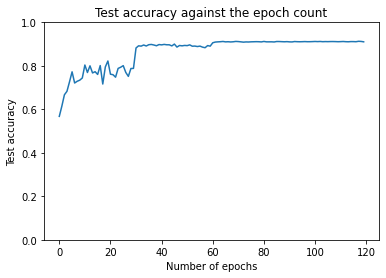

In [3]:
from IPython.display import Image
Image(filename='q2t1.png')

### For (2) $\nu=$[2,2,2,2], $c_u=c_f=64$.

### Show your code 
### Show the print and plots 

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import  torch.nn.functional as F
import torch.optim as optim
import torchvision
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

use_cuda = torch.cuda.is_available()
print('Use GPU?', use_cuda)


class MgIte(nn.Module):
    def __init__(self, A, S):
        super().__init__()
        
        self.A = A
        self.S = S
        self.bn1 =nn.BatchNorm2d(A.weight.size(0)) ##### For MgNet: BN #####
        self.bn2 =nn.BatchNorm2d(S.weight.size(0)) ##### For MgNet: BN #####
    
    def forward(self, out):
        u, f = out
        u = u + F.relu(self.bn2(self.S(F.relu(self.bn1((f-self.A(u))))))) ##### For MgNet: add BN and ReLU #####
        out = (u, f)
        return out


class MgRestriction(nn.Module):
    def __init__(self, A_old, A, Pi, R):
        super().__init__()

        self.A_old = A_old
        self.A = A
        self.Pi = Pi
        self.R = R
        self.bn1 = nn.BatchNorm2d(Pi.weight.size(0))   ##### For MgNet: BN #####
        self.bn2 = nn.BatchNorm2d(R.weight.size(0))    ##### For MgNet: BN #####

    def forward(self, out):
        u_old, f_old = out
        u = F.relu(self.bn1(self.Pi(u_old)))                              ##### For MgNet: add BN and ReLU #####
        f = F.relu(self.bn2(self.R(f_old-self.A_old(u_old)))) + self.A(u) ##### For MgNet: add BN and ReLU #####        
        out = (u,f)
        return out


class MG(nn.Module):
    def __init__(self, num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes):
        super().__init__()
        self.num_iteration = num_iteration
        self.num_channel_u = num_channel_u
        
        ##### For MgNet: Initialization layer #####
        self.conv1 = nn.Conv2d(num_channel_input, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_channel_f)        
        
        A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)
        S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)

        layers = []
        for l, num_iteration_l in enumerate(num_iteration): #l: l-th layer.   num_iteration_l: the number of iterations of l-th layer
            for i in range(num_iteration_l):
                layers.append(MgIte(A, S))

            setattr(self, 'layer'+str(l), nn.Sequential(*layers))

            if l < len(num_iteration)-1:
                A_old = A
                
                A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3,stride=1, padding=1, bias=False)
                S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)

                ##### For MgNet: padding=1 #####
                Pi = nn.Conv2d(num_channel_u, num_channel_u, kernel_size=3,stride=2, padding=1, bias=False)
                R = nn.Conv2d(num_channel_f, num_channel_f, kernel_size=3, stride=2, padding=1, bias=False)
                
                layers= [MgRestriction(A_old, A, Pi, R)]
        
        ##### For MgNet: average pooling and fully connected layer for classification #####
        self.pooling = nn.AdaptiveAvgPool2d(1)  # pooling the data in each channel to size=1
        self.fc = nn.Linear(num_channel_u ,num_classes)

    def forward(self, u, f):
        f = F.relu(self.bn1(self.conv1(f)))                 ##### For MgNet: initialization of f #####
        if use_cuda:                                        ##### For MgNet: initialization of u #####
            u = torch.zeros(f.size(0),self.num_channel_u,f.size(2),f.size(3), device=torch.device('cuda'))
        else:
            u = torch.zeros(f.size(0),self.num_channel_u,f.size(2),f.size(3))        
        out = (u, f)

        for l in range(len(self.num_iteration)):
            out = getattr(self, 'layer'+str(l))(out)
        
        ##### For MgNet: average pooling and fully connected layer for classification #####
        u, f = out       
        u = self.pooling(u)
        u = u.view(u.shape[0], -1)
        u = self.fc(u)
        return u

# Divide the learning rate by 10 every 30 epochs
def adjust_learning_rate(optimizer, epoch, init_lr):
    lr = init_lr * 0.1 ** (epoch // 30)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

minibatch_size = 128
num_epochs = 120
lr = 0.1

print("Problem 2 task (2): v=[2,2,2,2], cu=cf=64")
print("Part a:")
num_channel_input = 3
num_channel_u = 64
num_channel_f = 64
num_classes = 10
num_iteration = [2,2,2,2]

# Step 1: Define a model
my_model = MG(num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes)

if use_cuda:
    my_model = my_model.cuda()

# Step 2: Define a loss function and training algorithm
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_model.parameters(), lr=lr, momentum=0.9, weight_decay = 0.0005)

# Step 3: load dataset
normalize = torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
transform_train = torchvision.transforms.Compose([torchvision.transforms.RandomCrop(32, padding=4),
                                                  torchvision.transforms.RandomHorizontalFlip(),
                                                  torchvision.transforms.ToTensor(),
                                                  normalize])
transform_test  = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),normalize])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=minibatch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=minibatch_size, shuffle=False)
start = timer()

accuracy_history = []
#Step 4: Train the NNs
# One epoch is when an entire dataset is passed through the neural network only once.
for epoch in range(num_epochs):

    current_lr = adjust_learning_rate(optimizer, epoch, lr)

    my_model.train()
    for i, (images, labels) in enumerate(trainloader):
        if use_cuda:
          images = images.cuda()
          labels = labels.cuda()

        # Forward pass to get the loss
        outputs = my_model(0,images)   # We need additional 0 input for u in MgNet
        loss = criterion(outputs, labels)
        
        # Backward and compute the gradient
        optimizer.zero_grad()
        loss.backward()  #backpropragation
        optimizer.step() #update the weights/parameters

  # Training accuracy
    my_model.eval()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(trainloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()  
          outputs = my_model(0,images)  # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    training_accuracy = float(correct)/total

    # Test accuracy
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(testloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()
          outputs = my_model(0,images)      # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum()
    test_accuracy = float(correct)/total
    print('Epoch: {}, learning rate: {}, the training accuracy: {}, the test accuracy: {}' .format(epoch+1,current_lr,training_accuracy,test_accuracy)) 
    accuracy_history.append(test_accuracy)

end = timer()
print('Total Computation Time:',end - start)

# Part b: plot test accuracy
print("\nPart b: plot test accuracy")
def plot_accuracy(num_epochs,accuracy_history):
    plt.figure()
    plt.title('Test accuracy against the epoch count')
    plot = plt.plot(accuracy_history)
    plt.xlabel('Number of epochs')
    plt.ylim(0, 1)
    plt.ylabel('Test accuracy')
    plt.show()
plot_accuracy(num_epochs, accuracy_history)


# Calculate model size
model_size = sum(param.numel() for param in my_model.parameters())
print("\nPart c: model size:", model_size)

In [ ]:
# # (2) output:
# 
# Use GPU? True
# Problem 2 task (2): v=[2,2,2,2], cu=cf=64
# Part a:
# Files already downloaded and verified
# Files already downloaded and verified
# Epoch: 1, learning rate: 0.1, the training accuracy: 0.42768, the test accuracy: 0.4251
# Epoch: 2, learning rate: 0.1, the training accuracy: 0.51066, the test accuracy: 0.503
# Epoch: 3, learning rate: 0.1, the training accuracy: 0.64052, the test accuracy: 0.6374
# Epoch: 4, learning rate: 0.1, the training accuracy: 0.6265, the test accuracy: 0.6184
# Epoch: 5, learning rate: 0.1, the training accuracy: 0.74922, the test accuracy: 0.7363
# Epoch: 6, learning rate: 0.1, the training accuracy: 0.74068, the test accuracy: 0.7315
# Epoch: 7, learning rate: 0.1, the training accuracy: 0.77846, the test accuracy: 0.7574
# Epoch: 8, learning rate: 0.1, the training accuracy: 0.7921, the test accuracy: 0.7792
# Epoch: 9, learning rate: 0.1, the training accuracy: 0.7762, the test accuracy: 0.7756
# Epoch: 10, learning rate: 0.1, the training accuracy: 0.74852, the test accuracy: 0.7396
# Epoch: 11, learning rate: 0.1, the training accuracy: 0.74872, the test accuracy: 0.7282
# Epoch: 12, learning rate: 0.1, the training accuracy: 0.74092, the test accuracy: 0.7333
# Epoch: 13, learning rate: 0.1, the training accuracy: 0.80014, the test accuracy: 0.7861
# Epoch: 14, learning rate: 0.1, the training accuracy: 0.773, the test accuracy: 0.7571
# Epoch: 15, learning rate: 0.1, the training accuracy: 0.78992, the test accuracy: 0.7881
# Epoch: 16, learning rate: 0.1, the training accuracy: 0.75274, the test accuracy: 0.7439
# Epoch: 17, learning rate: 0.1, the training accuracy: 0.70374, the test accuracy: 0.7003
# Epoch: 18, learning rate: 0.1, the training accuracy: 0.76956, the test accuracy: 0.7615
# Epoch: 19, learning rate: 0.1, the training accuracy: 0.8321, the test accuracy: 0.816
# Epoch: 20, learning rate: 0.1, the training accuracy: 0.81178, the test accuracy: 0.8022
# Epoch: 21, learning rate: 0.1, the training accuracy: 0.79198, the test accuracy: 0.7744
# Epoch: 22, learning rate: 0.1, the training accuracy: 0.79686, the test accuracy: 0.7834
# Epoch: 23, learning rate: 0.1, the training accuracy: 0.74188, the test accuracy: 0.7299
# Epoch: 24, learning rate: 0.1, the training accuracy: 0.77118, the test accuracy: 0.7568
# Epoch: 25, learning rate: 0.1, the training accuracy: 0.84942, the test accuracy: 0.8364
# Epoch: 26, learning rate: 0.1, the training accuracy: 0.79408, the test accuracy: 0.7765
# Epoch: 27, learning rate: 0.1, the training accuracy: 0.81872, the test accuracy: 0.8121
# Epoch: 28, learning rate: 0.1, the training accuracy: 0.81814, the test accuracy: 0.8027
# Epoch: 29, learning rate: 0.1, the training accuracy: 0.80196, the test accuracy: 0.788
# Epoch: 30, learning rate: 0.1, the training accuracy: 0.82594, the test accuracy: 0.8075
# Epoch: 31, learning rate: 0.010000000000000002, the training accuracy: 0.92432, the test accuracy: 0.9016
# Epoch: 32, learning rate: 0.010000000000000002, the training accuracy: 0.932, the test accuracy: 0.906
# Epoch: 33, learning rate: 0.010000000000000002, the training accuracy: 0.93634, the test accuracy: 0.9102
# Epoch: 34, learning rate: 0.010000000000000002, the training accuracy: 0.94092, the test accuracy: 0.9091
# Epoch: 35, learning rate: 0.010000000000000002, the training accuracy: 0.94064, the test accuracy: 0.9091
# Epoch: 36, learning rate: 0.010000000000000002, the training accuracy: 0.94256, the test accuracy: 0.9051
# Epoch: 37, learning rate: 0.010000000000000002, the training accuracy: 0.94904, the test accuracy: 0.9129
# Epoch: 38, learning rate: 0.010000000000000002, the training accuracy: 0.95018, the test accuracy: 0.9112
# Epoch: 39, learning rate: 0.010000000000000002, the training accuracy: 0.95146, the test accuracy: 0.9117
# Epoch: 40, learning rate: 0.010000000000000002, the training accuracy: 0.95074, the test accuracy: 0.9103
# Epoch: 41, learning rate: 0.010000000000000002, the training accuracy: 0.94908, the test accuracy: 0.9097
# Epoch: 42, learning rate: 0.010000000000000002, the training accuracy: 0.94878, the test accuracy: 0.9075
# Epoch: 43, learning rate: 0.010000000000000002, the training accuracy: 0.95664, the test accuracy: 0.9102
# Epoch: 44, learning rate: 0.010000000000000002, the training accuracy: 0.94822, the test accuracy: 0.9037
# Epoch: 45, learning rate: 0.010000000000000002, the training accuracy: 0.95258, the test accuracy: 0.9076
# Epoch: 46, learning rate: 0.010000000000000002, the training accuracy: 0.9519, the test accuracy: 0.9089
# Epoch: 47, learning rate: 0.010000000000000002, the training accuracy: 0.94714, the test accuracy: 0.8963
# Epoch: 48, learning rate: 0.010000000000000002, the training accuracy: 0.95358, the test accuracy: 0.9038
# Epoch: 49, learning rate: 0.010000000000000002, the training accuracy: 0.95444, the test accuracy: 0.9097
# Epoch: 50, learning rate: 0.010000000000000002, the training accuracy: 0.95622, the test accuracy: 0.9053
# Epoch: 51, learning rate: 0.010000000000000002, the training accuracy: 0.94666, the test accuracy: 0.8946
# Epoch: 52, learning rate: 0.010000000000000002, the training accuracy: 0.95564, the test accuracy: 0.9038
# Epoch: 53, learning rate: 0.010000000000000002, the training accuracy: 0.957, the test accuracy: 0.9076
# Epoch: 54, learning rate: 0.010000000000000002, the training accuracy: 0.95556, the test accuracy: 0.9037
# Epoch: 55, learning rate: 0.010000000000000002, the training accuracy: 0.9577, the test accuracy: 0.908
# Epoch: 56, learning rate: 0.010000000000000002, the training accuracy: 0.95292, the test accuracy: 0.9003
# Epoch: 57, learning rate: 0.010000000000000002, the training accuracy: 0.9534, the test accuracy: 0.904
# Epoch: 58, learning rate: 0.010000000000000002, the training accuracy: 0.9506, the test accuracy: 0.9007
# Epoch: 59, learning rate: 0.010000000000000002, the training accuracy: 0.95902, the test accuracy: 0.9058
# Epoch: 60, learning rate: 0.010000000000000002, the training accuracy: 0.94208, the test accuracy: 0.8969
# Epoch: 61, learning rate: 0.0010000000000000002, the training accuracy: 0.97904, the test accuracy: 0.9224
# Epoch: 62, learning rate: 0.0010000000000000002, the training accuracy: 0.98206, the test accuracy: 0.9244
# Epoch: 63, learning rate: 0.0010000000000000002, the training accuracy: 0.98274, the test accuracy: 0.9222
# Epoch: 64, learning rate: 0.0010000000000000002, the training accuracy: 0.9845, the test accuracy: 0.9242
# Epoch: 65, learning rate: 0.0010000000000000002, the training accuracy: 0.98492, the test accuracy: 0.9244
# Epoch: 66, learning rate: 0.0010000000000000002, the training accuracy: 0.98602, the test accuracy: 0.9227
# Epoch: 67, learning rate: 0.0010000000000000002, the training accuracy: 0.98614, the test accuracy: 0.9229
# Epoch: 68, learning rate: 0.0010000000000000002, the training accuracy: 0.98766, the test accuracy: 0.9242
# Epoch: 69, learning rate: 0.0010000000000000002, the training accuracy: 0.98738, the test accuracy: 0.9229
# Epoch: 70, learning rate: 0.0010000000000000002, the training accuracy: 0.98816, the test accuracy: 0.924
# Epoch: 71, learning rate: 0.0010000000000000002, the training accuracy: 0.98894, the test accuracy: 0.9243
# Epoch: 72, learning rate: 0.0010000000000000002, the training accuracy: 0.98952, the test accuracy: 0.924
# Epoch: 73, learning rate: 0.0010000000000000002, the training accuracy: 0.98974, the test accuracy: 0.9263
# Epoch: 74, learning rate: 0.0010000000000000002, the training accuracy: 0.99008, the test accuracy: 0.9245
# Epoch: 75, learning rate: 0.0010000000000000002, the training accuracy: 0.9896, the test accuracy: 0.9232
# Epoch: 76, learning rate: 0.0010000000000000002, the training accuracy: 0.99048, the test accuracy: 0.9245
# Epoch: 77, learning rate: 0.0010000000000000002, the training accuracy: 0.98956, the test accuracy: 0.9235
# Epoch: 78, learning rate: 0.0010000000000000002, the training accuracy: 0.99162, the test accuracy: 0.924
# Epoch: 79, learning rate: 0.0010000000000000002, the training accuracy: 0.9913, the test accuracy: 0.9252
# Epoch: 80, learning rate: 0.0010000000000000002, the training accuracy: 0.99014, the test accuracy: 0.9238
# Epoch: 81, learning rate: 0.0010000000000000002, the training accuracy: 0.99092, the test accuracy: 0.9243
# Epoch: 82, learning rate: 0.0010000000000000002, the training accuracy: 0.99162, the test accuracy: 0.9251
# Epoch: 83, learning rate: 0.0010000000000000002, the training accuracy: 0.9923, the test accuracy: 0.9245
# Epoch: 84, learning rate: 0.0010000000000000002, the training accuracy: 0.99204, the test accuracy: 0.9262
# Epoch: 85, learning rate: 0.0010000000000000002, the training accuracy: 0.99254, the test accuracy: 0.9258
# Epoch: 86, learning rate: 0.0010000000000000002, the training accuracy: 0.9917, the test accuracy: 0.9244
# Epoch: 87, learning rate: 0.0010000000000000002, the training accuracy: 0.99198, the test accuracy: 0.9249
# Epoch: 88, learning rate: 0.0010000000000000002, the training accuracy: 0.99284, the test accuracy: 0.9256
# Epoch: 89, learning rate: 0.0010000000000000002, the training accuracy: 0.99272, the test accuracy: 0.9248
# Epoch: 90, learning rate: 0.0010000000000000002, the training accuracy: 0.99332, the test accuracy: 0.9262
# Epoch: 91, learning rate: 0.00010000000000000003, the training accuracy: 0.99368, the test accuracy: 0.9257
# Epoch: 92, learning rate: 0.00010000000000000003, the training accuracy: 0.99372, the test accuracy: 0.9257
# Epoch: 93, learning rate: 0.00010000000000000003, the training accuracy: 0.99364, the test accuracy: 0.9255
# Epoch: 94, learning rate: 0.00010000000000000003, the training accuracy: 0.99396, the test accuracy: 0.9268
# Epoch: 95, learning rate: 0.00010000000000000003, the training accuracy: 0.99388, the test accuracy: 0.9256
# Epoch: 96, learning rate: 0.00010000000000000003, the training accuracy: 0.99342, the test accuracy: 0.9262
# Epoch: 97, learning rate: 0.00010000000000000003, the training accuracy: 0.99428, the test accuracy: 0.9267
# Epoch: 98, learning rate: 0.00010000000000000003, the training accuracy: 0.99428, the test accuracy: 0.9264
# Epoch: 99, learning rate: 0.00010000000000000003, the training accuracy: 0.99406, the test accuracy: 0.9263
# Epoch: 100, learning rate: 0.00010000000000000003, the training accuracy: 0.99432, the test accuracy: 0.9265
# Epoch: 101, learning rate: 0.00010000000000000003, the training accuracy: 0.99392, the test accuracy: 0.927
# Epoch: 102, learning rate: 0.00010000000000000003, the training accuracy: 0.99446, the test accuracy: 0.9267
# Epoch: 103, learning rate: 0.00010000000000000003, the training accuracy: 0.99468, the test accuracy: 0.9257
# Epoch: 104, learning rate: 0.00010000000000000003, the training accuracy: 0.99474, the test accuracy: 0.9256
# Epoch: 105, learning rate: 0.00010000000000000003, the training accuracy: 0.99468, the test accuracy: 0.9265
# Epoch: 106, learning rate: 0.00010000000000000003, the training accuracy: 0.99446, the test accuracy: 0.927
# Epoch: 107, learning rate: 0.00010000000000000003, the training accuracy: 0.99442, the test accuracy: 0.9258
# Epoch: 108, learning rate: 0.00010000000000000003, the training accuracy: 0.9948, the test accuracy: 0.9258
# Epoch: 109, learning rate: 0.00010000000000000003, the training accuracy: 0.99412, the test accuracy: 0.9264
# Epoch: 110, learning rate: 0.00010000000000000003, the training accuracy: 0.99422, the test accuracy: 0.9257
# Epoch: 111, learning rate: 0.00010000000000000003, the training accuracy: 0.9941, the test accuracy: 0.9258
# Epoch: 112, learning rate: 0.00010000000000000003, the training accuracy: 0.99418, the test accuracy: 0.9257
# Epoch: 113, learning rate: 0.00010000000000000003, the training accuracy: 0.99452, the test accuracy: 0.9261
# Epoch: 114, learning rate: 0.00010000000000000003, the training accuracy: 0.99488, the test accuracy: 0.925
# Epoch: 115, learning rate: 0.00010000000000000003, the training accuracy: 0.99528, the test accuracy: 0.9255
# Epoch: 116, learning rate: 0.00010000000000000003, the training accuracy: 0.99458, the test accuracy: 0.9252
# Epoch: 117, learning rate: 0.00010000000000000003, the training accuracy: 0.99464, the test accuracy: 0.9249
# Epoch: 118, learning rate: 0.00010000000000000003, the training accuracy: 0.99492, the test accuracy: 0.9253
# Epoch: 119, learning rate: 0.00010000000000000003, the training accuracy: 0.99534, the test accuracy: 0.9262
# Epoch: 120, learning rate: 0.00010000000000000003, the training accuracy: 0.99496, the test accuracy: 0.9255
# Total Computation Time: 7086.101434441998

# Part b: plot test accuracy

# Part c: model size: 521418

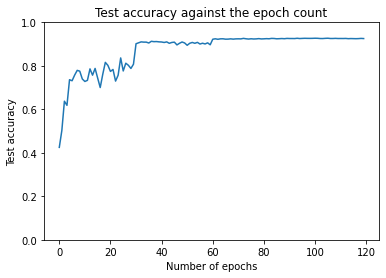

In [4]:
from IPython.display import Image
Image(filename='q2t2.png')

### For (3) $\nu=$[2,2,2,2], $c_u=c_f=64$, MgNet with $S^{l,i}$

### Show your code 
### Show the print and plots 

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import  torch.nn.functional as F
import torch.optim as optim
import torchvision
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

use_cuda = torch.cuda.is_available()
print('Use GPU?', use_cuda)


class MgIte(nn.Module):
    def __init__(self, A, S):
        super().__init__()
        
        self.A = A
        self.S = S
        self.bn1 =nn.BatchNorm2d(A.weight.size(0)) ##### For MgNet: BN #####
        self.bn2 =nn.BatchNorm2d(S.weight.size(0)) ##### For MgNet: BN #####
    
    def forward(self, out):
        u, f = out
        u = u + F.relu(self.bn2(self.S(F.relu(self.bn1((f-self.A(u))))))) ##### For MgNet: add BN and ReLU #####
        out = (u, f)
        return out


class MgRestriction(nn.Module):
    def __init__(self, A_old, A, Pi, R):
        super().__init__()

        self.A_old = A_old
        self.A = A
        self.Pi = Pi
        self.R = R
        self.bn1 = nn.BatchNorm2d(Pi.weight.size(0))   ##### For MgNet: BN #####
        self.bn2 = nn.BatchNorm2d(R.weight.size(0))    ##### For MgNet: BN #####

    def forward(self, out):
        u_old, f_old = out
        u = F.relu(self.bn1(self.Pi(u_old)))                              ##### For MgNet: add BN and ReLU #####
        f = F.relu(self.bn2(self.R(f_old-self.A_old(u_old)))) + self.A(u) ##### For MgNet: add BN and ReLU #####        
        out = (u,f)
        return out


class MG(nn.Module):
    def __init__(self, num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes):
        super().__init__()
        self.num_iteration = num_iteration
        self.num_channel_u = num_channel_u
        
        ##### For MgNet: Initialization layer #####
        self.conv1 = nn.Conv2d(num_channel_input, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_channel_f)        
        
        A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)

        layers = []
        for l, num_iteration_l in enumerate(num_iteration): #l: l-th layer.   num_iteration_l: the number of iterations of l-th layer
            for i in range(num_iteration_l):

                # Try to improve the test accuracy by implementing MgNet with S^l,i
                S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)
                layers.append(MgIte(A, S))

            setattr(self, 'layer'+str(l), nn.Sequential(*layers))

            if l < len(num_iteration)-1:
                A_old = A
                
                A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3,stride=1, padding=1, bias=False)

                ##### For MgNet: padding=1 #####
                Pi = nn.Conv2d(num_channel_u, num_channel_u, kernel_size=3,stride=2, padding=1, bias=False)
                R = nn.Conv2d(num_channel_f, num_channel_f, kernel_size=3, stride=2, padding=1, bias=False)
                
                layers= [MgRestriction(A_old, A, Pi, R)]
        
        ##### For MgNet: average pooling and fully connected layer for classification #####
        self.pooling = nn.AdaptiveAvgPool2d(1)  # pooling the data in each channel to size=1
        self.fc = nn.Linear(num_channel_u ,num_classes)

    def forward(self, u, f):
        f = F.relu(self.bn1(self.conv1(f)))                 ##### For MgNet: initialization of f #####
        if use_cuda:                                        ##### For MgNet: initialization of u #####
            u = torch.zeros(f.size(0),self.num_channel_u,f.size(2),f.size(3), device=torch.device('cuda'))
        else:
            u = torch.zeros(f.size(0),self.num_channel_u,f.size(2),f.size(3))        
        out = (u, f)

        for l in range(len(self.num_iteration)):
            out = getattr(self, 'layer'+str(l))(out)
        
        ##### For MgNet: average pooling and fully connected layer for classification #####
        u, f = out       
        u = self.pooling(u)
        u = u.view(u.shape[0], -1)
        u = self.fc(u)
        return u

# Divide the learning rate by 10 every 30 epochs
def adjust_learning_rate(optimizer, epoch, init_lr):
    lr = init_lr * 0.1 ** (epoch // 30)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

minibatch_size = 128
num_epochs = 120
lr = 0.1

print("Problem 2 task (3): v=[2,2,2,2], cu=cf=64, with S^l,i")
print("Part a:")
num_channel_input = 3
num_channel_u = 64
num_channel_f = 64
num_classes = 10
num_iteration = [2,2,2,2]

# Step 1: Define a model
my_model = MG(num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes)

if use_cuda:
    my_model = my_model.cuda()

# Step 2: Define a loss function and training algorithm
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_model.parameters(), lr=lr, momentum=0.9, weight_decay = 0.0005)

# Step 3: load dataset
normalize = torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
transform_train = torchvision.transforms.Compose([torchvision.transforms.RandomCrop(32, padding=4),
                                                  torchvision.transforms.RandomHorizontalFlip(),
                                                  torchvision.transforms.ToTensor(),
                                                  normalize])
transform_test  = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),normalize])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=minibatch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=minibatch_size, shuffle=False)
start = timer()

accuracy_history = []
#Step 4: Train the NNs
# One epoch is when an entire dataset is passed through the neural network only once.
for epoch in range(num_epochs):

    current_lr = adjust_learning_rate(optimizer, epoch, lr)

    my_model.train()
    for i, (images, labels) in enumerate(trainloader):
        if use_cuda:
          images = images.cuda()
          labels = labels.cuda()

        # Forward pass to get the loss
        outputs = my_model(0,images)   # We need additional 0 input for u in MgNet
        loss = criterion(outputs, labels)
        
        # Backward and compute the gradient
        optimizer.zero_grad()
        loss.backward()  #backpropragation
        optimizer.step() #update the weights/parameters

  # Training accuracy
    my_model.eval()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(trainloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()  
          outputs = my_model(0,images)  # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    training_accuracy = float(correct)/total

    # Test accuracy
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(testloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()
          outputs = my_model(0,images)      # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum()
    test_accuracy = float(correct)/total
    print('Epoch: {}, learning rate: {}, the training accuracy: {}, the test accuracy: {}' .format(epoch+1,current_lr,training_accuracy,test_accuracy)) 
    accuracy_history.append(test_accuracy)

end = timer()
print('Total Computation Time:',end - start)

# Part b: plot test accuracy
print("\nPart b: plot test accuracy")
def plot_accuracy(num_epochs,accuracy_history):
    plt.figure()
    plt.title('Test accuracy against the epoch count')
    plot = plt.plot(accuracy_history)
    plt.xlabel('Number of epochs')
    plt.ylim(0, 1)
    plt.ylabel('Test accuracy')
    plt.show()
plot_accuracy(num_epochs, accuracy_history)


# Calculate model size
model_size = sum(param.numel() for param in my_model.parameters())
print("\nPart c: model size:", model_size)

In [ ]:
# # (3) output:

# Use GPU? True
# Problem 2 task (3): v=[2,2,2,2], cu=cf=64, with S^l,i
# Part a:
# Files already downloaded and verified
# Files already downloaded and verified
# Epoch: 1, learning rate: 0.1, the training accuracy: 0.52454, the test accuracy: 0.5281
# Epoch: 2, learning rate: 0.1, the training accuracy: 0.5756, the test accuracy: 0.573
# Epoch: 3, learning rate: 0.1, the training accuracy: 0.71116, the test accuracy: 0.7034
# Epoch: 4, learning rate: 0.1, the training accuracy: 0.71518, the test accuracy: 0.7023
# Epoch: 5, learning rate: 0.1, the training accuracy: 0.7309, the test accuracy: 0.7193
# Epoch: 6, learning rate: 0.1, the training accuracy: 0.7236, the test accuracy: 0.7058
# Epoch: 7, learning rate: 0.1, the training accuracy: 0.7474, the test accuracy: 0.7359
# Epoch: 8, learning rate: 0.1, the training accuracy: 0.73764, the test accuracy: 0.7265
# Epoch: 9, learning rate: 0.1, the training accuracy: 0.74372, the test accuracy: 0.7263
# Epoch: 10, learning rate: 0.1, the training accuracy: 0.75276, the test accuracy: 0.7389
# Epoch: 11, learning rate: 0.1, the training accuracy: 0.75256, the test accuracy: 0.7365
# Epoch: 12, learning rate: 0.1, the training accuracy: 0.77462, the test accuracy: 0.7583
# Epoch: 13, learning rate: 0.1, the training accuracy: 0.8058, the test accuracy: 0.7887
# Epoch: 14, learning rate: 0.1, the training accuracy: 0.79186, the test accuracy: 0.776
# Epoch: 15, learning rate: 0.1, the training accuracy: 0.80328, the test accuracy: 0.7731
# Epoch: 16, learning rate: 0.1, the training accuracy: 0.81056, the test accuracy: 0.7976
# Epoch: 17, learning rate: 0.1, the training accuracy: 0.82176, the test accuracy: 0.8171
# Epoch: 18, learning rate: 0.1, the training accuracy: 0.82944, the test accuracy: 0.8195
# Epoch: 19, learning rate: 0.1, the training accuracy: 0.8089, the test accuracy: 0.7905
# Epoch: 20, learning rate: 0.1, the training accuracy: 0.80934, the test accuracy: 0.7822
# Epoch: 21, learning rate: 0.1, the training accuracy: 0.84286, the test accuracy: 0.8245
# Epoch: 22, learning rate: 0.1, the training accuracy: 0.85182, the test accuracy: 0.8391
# Epoch: 23, learning rate: 0.1, the training accuracy: 0.83868, the test accuracy: 0.8147
# Epoch: 24, learning rate: 0.1, the training accuracy: 0.75426, the test accuracy: 0.7338
# Epoch: 25, learning rate: 0.1, the training accuracy: 0.81984, the test accuracy: 0.7956
# Epoch: 26, learning rate: 0.1, the training accuracy: 0.78468, the test accuracy: 0.7745
# Epoch: 27, learning rate: 0.1, the training accuracy: 0.75064, the test accuracy: 0.7307
# Epoch: 28, learning rate: 0.1, the training accuracy: 0.80342, the test accuracy: 0.7707
# Epoch: 29, learning rate: 0.1, the training accuracy: 0.83502, the test accuracy: 0.8147
# Epoch: 30, learning rate: 0.1, the training accuracy: 0.82724, the test accuracy: 0.8026
# Epoch: 31, learning rate: 0.010000000000000002, the training accuracy: 0.92702, the test accuracy: 0.9008
# Epoch: 32, learning rate: 0.010000000000000002, the training accuracy: 0.93668, the test accuracy: 0.906
# Epoch: 33, learning rate: 0.010000000000000002, the training accuracy: 0.93964, the test accuracy: 0.9085
# Epoch: 34, learning rate: 0.010000000000000002, the training accuracy: 0.94356, the test accuracy: 0.9091
# Epoch: 35, learning rate: 0.010000000000000002, the training accuracy: 0.94718, the test accuracy: 0.9132
# Epoch: 36, learning rate: 0.010000000000000002, the training accuracy: 0.94756, the test accuracy: 0.9104
# Epoch: 37, learning rate: 0.010000000000000002, the training accuracy: 0.95368, the test accuracy: 0.9131
# Epoch: 38, learning rate: 0.010000000000000002, the training accuracy: 0.95546, the test accuracy: 0.9145
# Epoch: 39, learning rate: 0.010000000000000002, the training accuracy: 0.9545, the test accuracy: 0.9105
# Epoch: 40, learning rate: 0.010000000000000002, the training accuracy: 0.94994, the test accuracy: 0.9085
# Epoch: 41, learning rate: 0.010000000000000002, the training accuracy: 0.95276, the test accuracy: 0.9052
# Epoch: 42, learning rate: 0.010000000000000002, the training accuracy: 0.9618, the test accuracy: 0.9163
# Epoch: 43, learning rate: 0.010000000000000002, the training accuracy: 0.95888, the test accuracy: 0.9124
# Epoch: 44, learning rate: 0.010000000000000002, the training accuracy: 0.96234, the test accuracy: 0.9165
# Epoch: 45, learning rate: 0.010000000000000002, the training accuracy: 0.96036, the test accuracy: 0.9105
# Epoch: 46, learning rate: 0.010000000000000002, the training accuracy: 0.9641, the test accuracy: 0.9121
# Epoch: 47, learning rate: 0.010000000000000002, the training accuracy: 0.95858, the test accuracy: 0.9096
# Epoch: 48, learning rate: 0.010000000000000002, the training accuracy: 0.96496, the test accuracy: 0.9109
# Epoch: 49, learning rate: 0.010000000000000002, the training accuracy: 0.96184, the test accuracy: 0.9068
# Epoch: 50, learning rate: 0.010000000000000002, the training accuracy: 0.96196, the test accuracy: 0.9055
# Epoch: 51, learning rate: 0.010000000000000002, the training accuracy: 0.95284, the test accuracy: 0.9002
# Epoch: 52, learning rate: 0.010000000000000002, the training accuracy: 0.95966, the test accuracy: 0.9095
# Epoch: 53, learning rate: 0.010000000000000002, the training accuracy: 0.96278, the test accuracy: 0.9039
# Epoch: 54, learning rate: 0.010000000000000002, the training accuracy: 0.96448, the test accuracy: 0.9085
# Epoch: 55, learning rate: 0.010000000000000002, the training accuracy: 0.96522, the test accuracy: 0.909
# Epoch: 56, learning rate: 0.010000000000000002, the training accuracy: 0.95946, the test accuracy: 0.9071
# Epoch: 57, learning rate: 0.010000000000000002, the training accuracy: 0.9564, the test accuracy: 0.9028
# Epoch: 58, learning rate: 0.010000000000000002, the training accuracy: 0.95256, the test accuracy: 0.9022
# Epoch: 59, learning rate: 0.010000000000000002, the training accuracy: 0.96456, the test accuracy: 0.9082
# Epoch: 60, learning rate: 0.010000000000000002, the training accuracy: 0.95828, the test accuracy: 0.9001
# Epoch: 61, learning rate: 0.0010000000000000002, the training accuracy: 0.98262, the test accuracy: 0.9219
# Epoch: 62, learning rate: 0.0010000000000000002, the training accuracy: 0.98512, the test accuracy: 0.9232
# Epoch: 63, learning rate: 0.0010000000000000002, the training accuracy: 0.98688, the test accuracy: 0.9243
# Epoch: 64, learning rate: 0.0010000000000000002, the training accuracy: 0.98838, the test accuracy: 0.9241
# Epoch: 65, learning rate: 0.0010000000000000002, the training accuracy: 0.98908, the test accuracy: 0.9249
# Epoch: 66, learning rate: 0.0010000000000000002, the training accuracy: 0.99018, the test accuracy: 0.9241
# Epoch: 67, learning rate: 0.0010000000000000002, the training accuracy: 0.9898, the test accuracy: 0.9257
# Epoch: 68, learning rate: 0.0010000000000000002, the training accuracy: 0.99084, the test accuracy: 0.9253
# Epoch: 69, learning rate: 0.0010000000000000002, the training accuracy: 0.9903, the test accuracy: 0.9256
# Epoch: 70, learning rate: 0.0010000000000000002, the training accuracy: 0.99152, the test accuracy: 0.9252
# Epoch: 71, learning rate: 0.0010000000000000002, the training accuracy: 0.99178, the test accuracy: 0.9265
# Epoch: 72, learning rate: 0.0010000000000000002, the training accuracy: 0.99244, the test accuracy: 0.9275
# Epoch: 73, learning rate: 0.0010000000000000002, the training accuracy: 0.99202, the test accuracy: 0.9252
# Epoch: 74, learning rate: 0.0010000000000000002, the training accuracy: 0.9922, the test accuracy: 0.9257
# Epoch: 75, learning rate: 0.0010000000000000002, the training accuracy: 0.9928, the test accuracy: 0.9258
# Epoch: 76, learning rate: 0.0010000000000000002, the training accuracy: 0.9931, the test accuracy: 0.9244
# Epoch: 77, learning rate: 0.0010000000000000002, the training accuracy: 0.99376, the test accuracy: 0.9245
# Epoch: 78, learning rate: 0.0010000000000000002, the training accuracy: 0.9932, the test accuracy: 0.9233
# Epoch: 79, learning rate: 0.0010000000000000002, the training accuracy: 0.99362, the test accuracy: 0.9265
# Epoch: 80, learning rate: 0.0010000000000000002, the training accuracy: 0.99414, the test accuracy: 0.9246
# Epoch: 81, learning rate: 0.0010000000000000002, the training accuracy: 0.99486, the test accuracy: 0.9248
# Epoch: 82, learning rate: 0.0010000000000000002, the training accuracy: 0.9947, the test accuracy: 0.924
# Epoch: 83, learning rate: 0.0010000000000000002, the training accuracy: 0.99434, the test accuracy: 0.9255
# Epoch: 84, learning rate: 0.0010000000000000002, the training accuracy: 0.99458, the test accuracy: 0.9249
# Epoch: 85, learning rate: 0.0010000000000000002, the training accuracy: 0.99558, the test accuracy: 0.9251
# Epoch: 86, learning rate: 0.0010000000000000002, the training accuracy: 0.99548, the test accuracy: 0.9271
# Epoch: 87, learning rate: 0.0010000000000000002, the training accuracy: 0.99414, the test accuracy: 0.9245
# Epoch: 88, learning rate: 0.0010000000000000002, the training accuracy: 0.99514, the test accuracy: 0.9245
# Epoch: 89, learning rate: 0.0010000000000000002, the training accuracy: 0.9954, the test accuracy: 0.925
# Epoch: 90, learning rate: 0.0010000000000000002, the training accuracy: 0.99558, the test accuracy: 0.9245
# Epoch: 91, learning rate: 0.00010000000000000003, the training accuracy: 0.99582, the test accuracy: 0.9254
# Epoch: 92, learning rate: 0.00010000000000000003, the training accuracy: 0.99596, the test accuracy: 0.926
# Epoch: 93, learning rate: 0.00010000000000000003, the training accuracy: 0.99642, the test accuracy: 0.9261
# Epoch: 94, learning rate: 0.00010000000000000003, the training accuracy: 0.9964, the test accuracy: 0.9252
# Epoch: 95, learning rate: 0.00010000000000000003, the training accuracy: 0.9959, the test accuracy: 0.9262
# Epoch: 96, learning rate: 0.00010000000000000003, the training accuracy: 0.9964, the test accuracy: 0.9259
# Epoch: 97, learning rate: 0.00010000000000000003, the training accuracy: 0.99612, the test accuracy: 0.9259
# Epoch: 98, learning rate: 0.00010000000000000003, the training accuracy: 0.99678, the test accuracy: 0.9256
# Epoch: 99, learning rate: 0.00010000000000000003, the training accuracy: 0.99646, the test accuracy: 0.9265
# Epoch: 100, learning rate: 0.00010000000000000003, the training accuracy: 0.99634, the test accuracy: 0.9251
# Epoch: 101, learning rate: 0.00010000000000000003, the training accuracy: 0.9968, the test accuracy: 0.9264
# Epoch: 102, learning rate: 0.00010000000000000003, the training accuracy: 0.99614, the test accuracy: 0.9262
# Epoch: 103, learning rate: 0.00010000000000000003, the training accuracy: 0.99658, the test accuracy: 0.9263
# Epoch: 104, learning rate: 0.00010000000000000003, the training accuracy: 0.9965, the test accuracy: 0.9249
# Epoch: 105, learning rate: 0.00010000000000000003, the training accuracy: 0.99688, the test accuracy: 0.9263
# Epoch: 106, learning rate: 0.00010000000000000003, the training accuracy: 0.99652, the test accuracy: 0.9255
# Epoch: 107, learning rate: 0.00010000000000000003, the training accuracy: 0.99688, the test accuracy: 0.9259
# Epoch: 108, learning rate: 0.00010000000000000003, the training accuracy: 0.99688, the test accuracy: 0.9252
# Epoch: 109, learning rate: 0.00010000000000000003, the training accuracy: 0.99628, the test accuracy: 0.9241
# Epoch: 110, learning rate: 0.00010000000000000003, the training accuracy: 0.997, the test accuracy: 0.9257
# Epoch: 111, learning rate: 0.00010000000000000003, the training accuracy: 0.997, the test accuracy: 0.9261
# Epoch: 112, learning rate: 0.00010000000000000003, the training accuracy: 0.99734, the test accuracy: 0.9253
# Epoch: 113, learning rate: 0.00010000000000000003, the training accuracy: 0.99656, the test accuracy: 0.926
# Epoch: 114, learning rate: 0.00010000000000000003, the training accuracy: 0.9966, the test accuracy: 0.9259
# Epoch: 115, learning rate: 0.00010000000000000003, the training accuracy: 0.99712, the test accuracy: 0.925
# Epoch: 116, learning rate: 0.00010000000000000003, the training accuracy: 0.99714, the test accuracy: 0.9259
# Epoch: 117, learning rate: 0.00010000000000000003, the training accuracy: 0.99676, the test accuracy: 0.926
# Epoch: 118, learning rate: 0.00010000000000000003, the training accuracy: 0.997, the test accuracy: 0.9259
# Epoch: 119, learning rate: 0.00010000000000000003, the training accuracy: 0.9968, the test accuracy: 0.9249
# Epoch: 120, learning rate: 0.00010000000000000003, the training accuracy: 0.99718, the test accuracy: 0.9254
# Total Computation Time: 6541.125646377999

# Part b: plot test accuracy

# Part c: model size: 668874

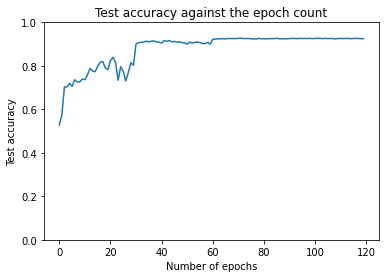

In [5]:
from IPython.display import Image
Image(filename='q2t3.png')

### Summary 

|      Model            | $c_u, c_f$ | $\nu$      | test accuracy $b^*$ |computational time | #parameters |
|:----------------------|:-----------|:-----------|:--------------------|:------------------|:------------|
| MgNet with $S^{l}$    |       64     |  [1,1,1,1] |91.29%                     |6755                   |520394             |
| MgNet with $S^{l}$    |64            |  [2,2,2,2] |92.68%                     |7086                   |521418             |
| MgNet with $S^{l,i}$  |64            |  [2,2,2,2] |92.71%                     |6542                   |668874             |

### Discussions or Conclusions

#### *  Conclusion: The model MgNet with $S^{l,i}$ with channel [2,2,2,2] has the highest test accuracy. 
#### *  The number of parameters is different as the model setting and channels are different. 

=================================================================================================================

## Problem 3 [25 %]:

Try to improve the MgNet Accuracy by increasing the number of channels. (We use the same notation as in the previous problem.) Double the number of channels to $c_u=c_f=128$ and try different $\nu$ to maximize the test accuracy.

### Tasks:
   * [20%] Report $b^{*}$, $\nu$ and the number of parameters of your model for each of the experiments you run.
   * [5%] For the best experiment, plot the test accuracy against the epoch count, i.e. the x-axis is the number of epochs $i$ and y-axis is the test accuracy $b_i$. (Same as for the previous problem.)

In [ ]:
# You can calculate the number of parameters of my_model by:
model_size = sum(param.numel() for param in my_model.parameters())


## Results of Problem 3:


In [ ]:

# import torch
# import numpy as np
# import torch.nn as nn
# import  torch.nn.functional as F
# import torch.optim as optim
# import torchvision
# from timeit import default_timer as timer
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D


# Use GPU? True
# Problem 3 task (3): v=[2,2,2,2], cu=cf=128, with S^l,i
# Part a:
# Files already downloaded and verified
# Files already downloaded and verified
# Epoch: 1, learning rate: 0.1, the training accuracy: 0.4819, the test accuracy: 0.494
# Epoch: 2, learning rate: 0.1, the training accuracy: 0.50622, the test accuracy: 0.5239
# Epoch: 3, learning rate: 0.1, the training accuracy: 0.62284, the test accuracy: 0.5991
# Epoch: 4, learning rate: 0.1, the training accuracy: 0.69404, the test accuracy: 0.6896
# Epoch: 5, learning rate: 0.1, the training accuracy: 0.70426, the test accuracy: 0.6965
# Epoch: 6, learning rate: 0.1, the training accuracy: 0.80528, the test accuracy: 0.7922
# Epoch: 7, learning rate: 0.1, the training accuracy: 0.7578, the test accuracy: 0.7429
# Epoch: 8, learning rate: 0.1, the training accuracy: 0.77944, the test accuracy: 0.772
# Epoch: 9, learning rate: 0.1, the training accuracy: 0.7896, the test accuracy: 0.7822
# Epoch: 10, learning rate: 0.1, the training accuracy: 0.80302, the test accuracy: 0.7899
# Epoch: 11, learning rate: 0.1, the training accuracy: 0.76602, the test accuracy: 0.767
# Epoch: 12, learning rate: 0.1, the training accuracy: 0.80168, the test accuracy: 0.7827
# Epoch: 13, learning rate: 0.1, the training accuracy: 0.82712, the test accuracy: 0.8202
# Epoch: 14, learning rate: 0.1, the training accuracy: 0.81258, the test accuracy: 0.796
# Epoch: 15, learning rate: 0.1, the training accuracy: 0.80594, the test accuracy: 0.7756
# Epoch: 16, learning rate: 0.1, the training accuracy: 0.84108, the test accuracy: 0.8197
# Epoch: 17, learning rate: 0.1, the training accuracy: 0.81318, the test accuracy: 0.7911
# Epoch: 18, learning rate: 0.1, the training accuracy: 0.83178, the test accuracy: 0.8066
# Epoch: 19, learning rate: 0.1, the training accuracy: 0.7853, the test accuracy: 0.7663
# Epoch: 20, learning rate: 0.1, the training accuracy: 0.81594, the test accuracy: 0.7934
# Epoch: 21, learning rate: 0.1, the training accuracy: 0.86938, the test accuracy: 0.84
# Epoch: 22, learning rate: 0.1, the training accuracy: 0.84698, the test accuracy: 0.8354
# Epoch: 23, learning rate: 0.1, the training accuracy: 0.78696, the test accuracy: 0.7613
# Epoch: 24, learning rate: 0.1, the training accuracy: 0.85806, the test accuracy: 0.8366
# Epoch: 25, learning rate: 0.1, the training accuracy: 0.81722, the test accuracy: 0.8058
# Epoch: 26, learning rate: 0.1, the training accuracy: 0.87186, the test accuracy: 0.8475
# Epoch: 27, learning rate: 0.1, the training accuracy: 0.86636, the test accuracy: 0.8408
# Epoch: 28, learning rate: 0.1, the training accuracy: 0.84778, the test accuracy: 0.8267
# Epoch: 29, learning rate: 0.1, the training accuracy: 0.8213, the test accuracy: 0.7891
# Epoch: 30, learning rate: 0.1, the training accuracy: 0.84512, the test accuracy: 0.8302
# Epoch: 31, learning rate: 0.010000000000000002, the training accuracy: 0.95036, the test accuracy: 0.9199
# Epoch: 32, learning rate: 0.010000000000000002, the training accuracy: 0.95744, the test accuracy: 0.9245
# Epoch: 33, learning rate: 0.010000000000000002, the training accuracy: 0.96206, the test accuracy: 0.9275
# Epoch: 34, learning rate: 0.010000000000000002, the training accuracy: 0.96616, the test accuracy: 0.9272
# Epoch: 35, learning rate: 0.010000000000000002, the training accuracy: 0.96928, the test accuracy: 0.9261
# Epoch: 36, learning rate: 0.010000000000000002, the training accuracy: 0.97174, the test accuracy: 0.9291
# Epoch: 37, learning rate: 0.010000000000000002, the training accuracy: 0.97188, the test accuracy: 0.927
# Epoch: 38, learning rate: 0.010000000000000002, the training accuracy: 0.97624, the test accuracy: 0.9261
# Epoch: 39, learning rate: 0.010000000000000002, the training accuracy: 0.97868, the test accuracy: 0.928
# Epoch: 40, learning rate: 0.010000000000000002, the training accuracy: 0.98074, the test accuracy: 0.9288
# Epoch: 41, learning rate: 0.010000000000000002, the training accuracy: 0.9811, the test accuracy: 0.927
# Epoch: 42, learning rate: 0.010000000000000002, the training accuracy: 0.98138, the test accuracy: 0.9297
# Epoch: 43, learning rate: 0.010000000000000002, the training accuracy: 0.98022, the test accuracy: 0.9252
# Epoch: 44, learning rate: 0.010000000000000002, the training accuracy: 0.98366, the test accuracy: 0.9272
# Epoch: 45, learning rate: 0.010000000000000002, the training accuracy: 0.9818, the test accuracy: 0.9251
# Epoch: 46, learning rate: 0.010000000000000002, the training accuracy: 0.97944, the test accuracy: 0.9223
# Epoch: 47, learning rate: 0.010000000000000002, the training accuracy: 0.98098, the test accuracy: 0.9195
# Epoch: 48, learning rate: 0.010000000000000002, the training accuracy: 0.98426, the test accuracy: 0.9279
# Epoch: 49, learning rate: 0.010000000000000002, the training accuracy: 0.98236, the test accuracy: 0.923
# Epoch: 50, learning rate: 0.010000000000000002, the training accuracy: 0.98232, the test accuracy: 0.9234
# Epoch: 51, learning rate: 0.010000000000000002, the training accuracy: 0.98102, the test accuracy: 0.9221
# Epoch: 52, learning rate: 0.010000000000000002, the training accuracy: 0.98246, the test accuracy: 0.9219
# Epoch: 53, learning rate: 0.010000000000000002, the training accuracy: 0.98312, the test accuracy: 0.928
# Epoch: 54, learning rate: 0.010000000000000002, the training accuracy: 0.98332, the test accuracy: 0.9265
# Epoch: 55, learning rate: 0.010000000000000002, the training accuracy: 0.98408, the test accuracy: 0.921
# Epoch: 56, learning rate: 0.010000000000000002, the training accuracy: 0.97456, the test accuracy: 0.9075
# Epoch: 57, learning rate: 0.010000000000000002, the training accuracy: 0.9771, the test accuracy: 0.9181
# Epoch: 58, learning rate: 0.010000000000000002, the training accuracy: 0.98112, the test accuracy: 0.9165
# Epoch: 59, learning rate: 0.010000000000000002, the training accuracy: 0.98166, the test accuracy: 0.9244
# Epoch: 60, learning rate: 0.010000000000000002, the training accuracy: 0.9759, the test accuracy: 0.9118
# Epoch: 61, learning rate: 0.0010000000000000002, the training accuracy: 0.99452, the test accuracy: 0.9351
# Epoch: 62, learning rate: 0.0010000000000000002, the training accuracy: 0.99628, the test accuracy: 0.937
# Epoch: 63, learning rate: 0.0010000000000000002, the training accuracy: 0.9972, the test accuracy: 0.9368
# Epoch: 64, learning rate: 0.0010000000000000002, the training accuracy: 0.9977, the test accuracy: 0.9371
# Epoch: 65, learning rate: 0.0010000000000000002, the training accuracy: 0.99824, the test accuracy: 0.9366
# Epoch: 66, learning rate: 0.0010000000000000002, the training accuracy: 0.99838, the test accuracy: 0.9375
# Epoch: 67, learning rate: 0.0010000000000000002, the training accuracy: 0.99814, the test accuracy: 0.9366
# Epoch: 68, learning rate: 0.0010000000000000002, the training accuracy: 0.9986, the test accuracy: 0.9389
# Epoch: 69, learning rate: 0.0010000000000000002, the training accuracy: 0.9986, the test accuracy: 0.9386
# Epoch: 70, learning rate: 0.0010000000000000002, the training accuracy: 0.99888, the test accuracy: 0.9382
# Epoch: 71, learning rate: 0.0010000000000000002, the training accuracy: 0.99892, the test accuracy: 0.9377
# Epoch: 72, learning rate: 0.0010000000000000002, the training accuracy: 0.9989, the test accuracy: 0.9374
# Epoch: 73, learning rate: 0.0010000000000000002, the training accuracy: 0.99898, the test accuracy: 0.9384
# Epoch: 74, learning rate: 0.0010000000000000002, the training accuracy: 0.99944, the test accuracy: 0.9374
# Epoch: 75, learning rate: 0.0010000000000000002, the training accuracy: 0.99932, the test accuracy: 0.9373
# Epoch: 76, learning rate: 0.0010000000000000002, the training accuracy: 0.99916, the test accuracy: 0.9379
# Epoch: 77, learning rate: 0.0010000000000000002, the training accuracy: 0.99938, the test accuracy: 0.9386
# Epoch: 78, learning rate: 0.0010000000000000002, the training accuracy: 0.9994, the test accuracy: 0.9395
# Epoch: 79, learning rate: 0.0010000000000000002, the training accuracy: 0.99928, the test accuracy: 0.9378
# Epoch: 80, learning rate: 0.0010000000000000002, the training accuracy: 0.99934, the test accuracy: 0.9383
# Epoch: 81, learning rate: 0.0010000000000000002, the training accuracy: 0.99932, the test accuracy: 0.9389
# Epoch: 82, learning rate: 0.0010000000000000002, the training accuracy: 0.99966, the test accuracy: 0.9386
# Epoch: 83, learning rate: 0.0010000000000000002, the training accuracy: 0.99956, the test accuracy: 0.9393
# Epoch: 84, learning rate: 0.0010000000000000002, the training accuracy: 0.99968, the test accuracy: 0.9378
# Epoch: 85, learning rate: 0.0010000000000000002, the training accuracy: 0.99966, the test accuracy: 0.939
# Epoch: 86, learning rate: 0.0010000000000000002, the training accuracy: 0.99946, the test accuracy: 0.9382
# Epoch: 87, learning rate: 0.0010000000000000002, the training accuracy: 0.9996, the test accuracy: 0.9385
# Epoch: 88, learning rate: 0.0010000000000000002, the training accuracy: 0.99958, the test accuracy: 0.9391
# Epoch: 89, learning rate: 0.0010000000000000002, the training accuracy: 0.99976, the test accuracy: 0.9385
# Epoch: 90, learning rate: 0.0010000000000000002, the training accuracy: 0.9996, the test accuracy: 0.9389
# Epoch: 91, learning rate: 0.00010000000000000003, the training accuracy: 0.99958, the test accuracy: 0.9389
# Epoch: 92, learning rate: 0.00010000000000000003, the training accuracy: 0.99958, the test accuracy: 0.939
# Epoch: 93, learning rate: 0.00010000000000000003, the training accuracy: 0.9997, the test accuracy: 0.9382
# Epoch: 94, learning rate: 0.00010000000000000003, the training accuracy: 0.99976, the test accuracy: 0.9398
# Epoch: 95, learning rate: 0.00010000000000000003, the training accuracy: 0.99976, the test accuracy: 0.9393
# Epoch: 96, learning rate: 0.00010000000000000003, the training accuracy: 0.99978, the test accuracy: 0.9378
# Epoch: 97, learning rate: 0.00010000000000000003, the training accuracy: 0.99974, the test accuracy: 0.9388
# Epoch: 98, learning rate: 0.00010000000000000003, the training accuracy: 0.99972, the test accuracy: 0.9386
# Epoch: 99, learning rate: 0.00010000000000000003, the training accuracy: 0.99976, the test accuracy: 0.9388
# Epoch: 100, learning rate: 0.00010000000000000003, the training accuracy: 0.99974, the test accuracy: 0.9398
# Epoch: 101, learning rate: 0.00010000000000000003, the training accuracy: 0.99984, the test accuracy: 0.9387
# Epoch: 102, learning rate: 0.00010000000000000003, the training accuracy: 0.99982, the test accuracy: 0.9389
# Epoch: 103, learning rate: 0.00010000000000000003, the training accuracy: 0.9998, the test accuracy: 0.938
# Epoch: 104, learning rate: 0.00010000000000000003, the training accuracy: 0.9996, the test accuracy: 0.939
# Epoch: 105, learning rate: 0.00010000000000000003, the training accuracy: 0.99966, the test accuracy: 0.9393
# Epoch: 106, learning rate: 0.00010000000000000003, the training accuracy: 0.9998, the test accuracy: 0.9386
# Epoch: 107, learning rate: 0.00010000000000000003, the training accuracy: 0.99982, the test accuracy: 0.94
# Epoch: 108, learning rate: 0.00010000000000000003, the training accuracy: 0.99962, the test accuracy: 0.9385
# Epoch: 109, learning rate: 0.00010000000000000003, the training accuracy: 0.99974, the test accuracy: 0.9384
# Epoch: 110, learning rate: 0.00010000000000000003, the training accuracy: 0.99978, the test accuracy: 0.939
# Epoch: 111, learning rate: 0.00010000000000000003, the training accuracy: 0.99976, the test accuracy: 0.9388
# Epoch: 112, learning rate: 0.00010000000000000003, the training accuracy: 0.99976, the test accuracy: 0.9384
# Epoch: 113, learning rate: 0.00010000000000000003, the training accuracy: 0.99964, the test accuracy: 0.9392
# Epoch: 114, learning rate: 0.00010000000000000003, the training accuracy: 0.99974, the test accuracy: 0.9391
# Epoch: 115, learning rate: 0.00010000000000000003, the training accuracy: 0.99968, the test accuracy: 0.9386
# Epoch: 116, learning rate: 0.00010000000000000003, the training accuracy: 0.99982, the test accuracy: 0.9386
# Epoch: 117, learning rate: 0.00010000000000000003, the training accuracy: 0.99972, the test accuracy: 0.9393
# Epoch: 118, learning rate: 0.00010000000000000003, the training accuracy: 0.99976, the test accuracy: 0.9393
# Epoch: 119, learning rate: 0.00010000000000000003, the training accuracy: 0.99978, the test accuracy: 0.9385
# Epoch: 120, learning rate: 0.00010000000000000003, the training accuracy: 0.9998, the test accuracy: 0.9383
# Total Computation Time: 10783.258270561

### Summary 

|                  | $c_u, c_f$ | $\nu$      | test accuracy $b^*$ |computational time | #parameters |
|:-----------------|:-----------|:-----------|:--------------------|:------------------|:------------|
|MgNet with $S^{l}$                  |128            |[1,1,1,1]            |91.06%                     |7593                   |2072970             |
|MgNet with $S^{l}$                  |128            |[2,2,2,2]            |87.99%                     |10908                   |2075018             |
|MgNet with $S^{l,i}$                  |128            |[2,2,2,2]            |94.0%                     |10784                   |2675312             |

### Discussions or Conclusions

#### *  Discussion: I accidentally clear the output for the first two models and didn't have enough time to run full 120 epochs. The actual test accuracy is around 93%
#### *. Conclusion: MgNet with $S^{l,i}$ with v=[2,2,2,2] has the highest test accuracy up to 94%, which also satisfies the requirements of problem 4.

### For the best experiment, plot the test accuracy against the epoch count

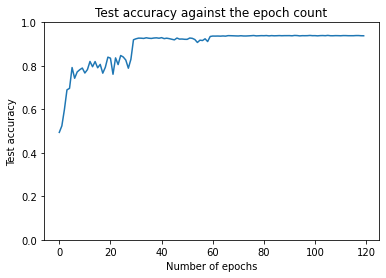

In [6]:
from IPython.display import Image
Image(filename='q3best.png')

=================================================================================================================

## Problem 4 [5%]:

Continue testing larger MgNet models (i.e. increase the number of channels) to maximize the test accuracy. (Again, we use the same notation as in problem 2.)

### Tasks:    
    
+  [5%] Try different training strategies and MgNet architectures with the goal of achieving $b^*>$ 95%. Hint: you can tune the number of epochs, the learning rate schedule, $c_u$, $c_f$, $\nu$, try different $S^{l,i}$ in the same layer $l$, etc...

## Results of Problem 4:


### Summary 

|    | $c_u, c_f$ | $\nu$     | test accuracy $b^*$ |computational time | #parameters|other parameters you tuned|
|:---|:-----------|:----------|:--------------------|:------------------|:-----------|:-------------------------|
|    |128            |[2,2,2,2]           |94.03%                     |10803                   |2664842            |None                          |
|    |            |           |                     |                   |            |                          |
|    |            |           |                     |                   |            |                          |


### Discussions or Conclusions

#### *  with cu=cf=128 and model MgNet with $S^{l,i}$, the test accuracy can reach 94%
#### *

=================================================================================================================

### Summary of all the problems

| Model   | $c_u, c_f$ | $\nu$     | test accuracy $b^*$ |computational time | #parameters|other parameters you tuned|
|:---|:-----------|:----------|:--------------------|:------------------|:-----------|:-------------------------|
|MgNet with $S^{l}$     |64            |[2,2,2,2]           |92.71%                     |6542                   |668874            |                          |
|MgNet with $S^{l,i}$    |128            |[2,2,2,2]            |94.0%                     |10784                   |2675312            |                          |
|MgNet with $S^{l,i}$     |128            |[2,2,2,2]            |94.0%                     |10803                   |2664842            |                          |